
<h1 style='font-size: 35px; color: crimson; font-family: Colonna MT; text-align: center; font-weight: 600'>Exploratory Data Analysis (EDA) of the Iris Flower Dataset | Detection and Handling Outliers</h1>

---

An outlier is a data point that significantly deviates from the rest of the dataset, appearing as an unusually high or low value. Outliers may arise from errors, data entry mistakes, or natural variations, and can distort statistical analysis and machine learning models. To maintain data integrity, outliers should be detected using methods like Z-scores, IQR, or visual tools (e.g., box plots), and then handled appropriately.

<h1 style='font-size: 20px; color: crimson; font-family: Perpetua; font-weight: 600'>1.0: Import Dataset and Required Libraries</h1>

In [9]:
import matplotlib.pyplot as plt  
import seaborn as sns  
import pandas as pd  
import numpy as np 
import math  

DATA_PATH = "../Datasets/iris_flower_data.csv"
df = pd.read_csv(DATA_PATH)
display(df.head(10))

,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa
5,5.40,3.90,1.70,0.40,setosa
6,4.60,3.40,1.40,0.30,setosa
7,5.00,3.40,1.50,0.20,setosa
8,4.40,2.90,1.40,0.20,setosa
9,4.90,3.10,1.50,0.10,setosa


<h1 style='font-size: 20px; color: crimson; font-family: Perpetua; font-weight: 600'>2.0: Visualize Outliers Using Boxplots</h1>

To gain a more visual and intuitive understanding of how outliers are distributed, we can use **boxplots**. Boxplots not only show the spread and center of the data but also clearly highlight outliers as individual points outside the whiskers, making it easy to see which variables and groups have more extreme values.

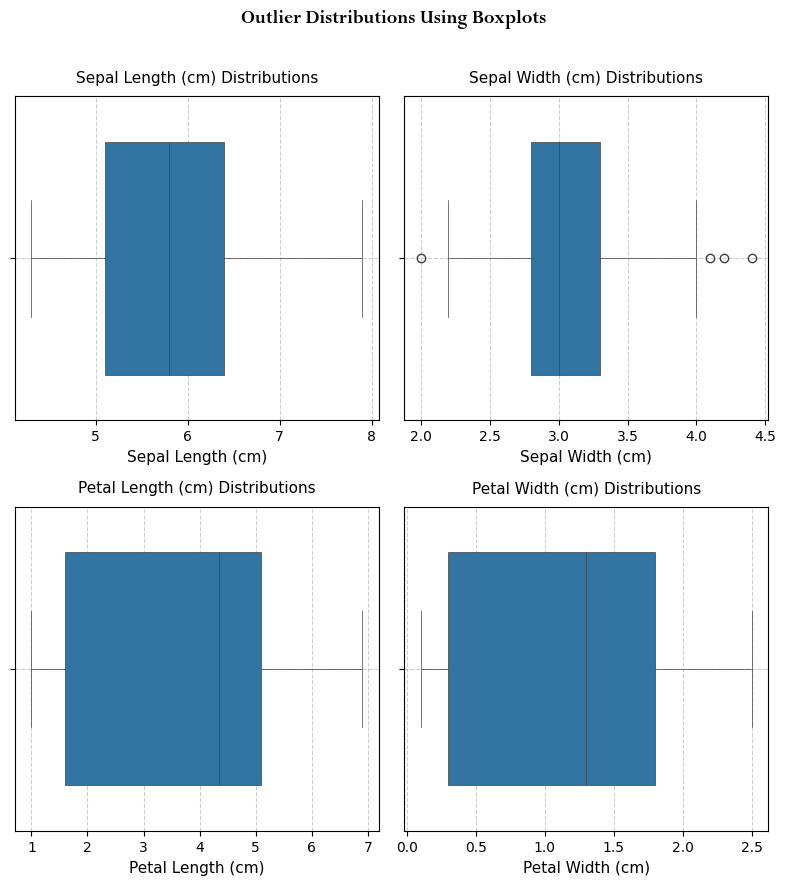

In [4]:
def plot_boxplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Perpetua', 'font.style': 'normal', 'font.size': 11 })
    fig.suptitle("Outlier Distributions Using Boxplots", fontsize=14, fontweight='bold')
    if group_col: fig.suptitle(f"Outlier Distributions Across {group_col} Using Boxplots", fontsize=14, fontweight='bold')

    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Metrics):
        sns.boxplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], gap=0.1, linewidth=0.5)   
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10)
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        if group_col: axes[idx].legend(frameon=False)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
Metrics = df.select_dtypes(include=[np.number]).columns
plot_boxplot(df, Metrics)

The current visualizations reveal the presence of potential outliers when analyzing the overall dataset, particularly in features like sepal width. While this provides a general overview, it does not account for species-level variability. To gain a clearer and more accurate understanding, the next step is to **diagnose outliers at the group level**, examining each Iris species separately. This approach helps determine whether the observed outliers are true anomalies or simply natural variations within specific species.


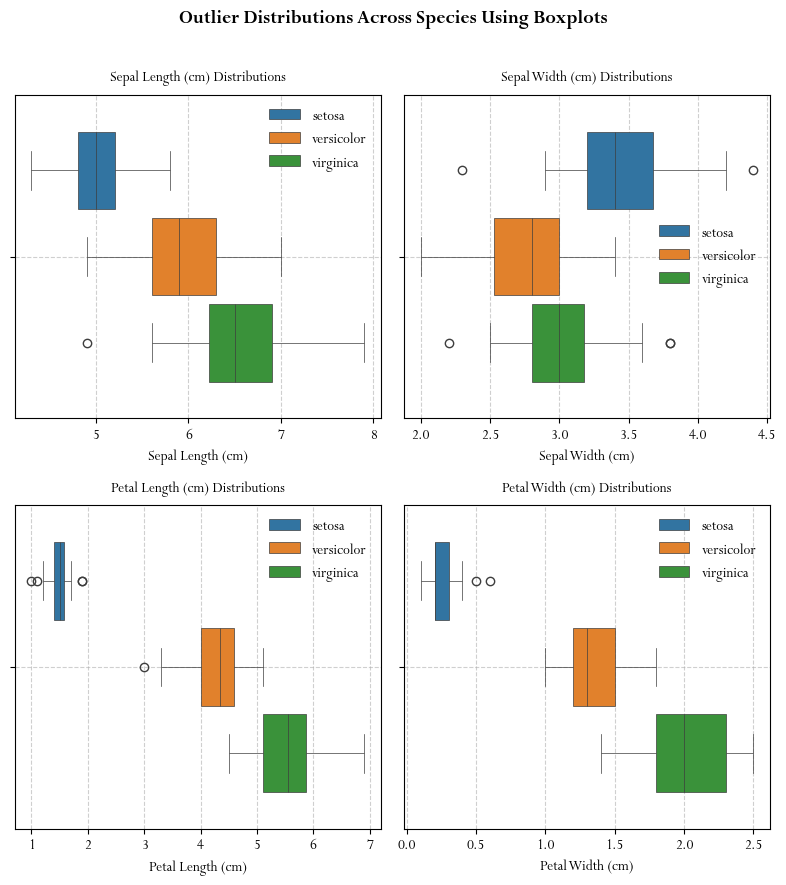

In [5]:
Metrics = df.select_dtypes(include=[np.number]).columns[:6]
plot_boxplot(df, Metrics, group_col='Species')

<h1 style='font-size: 20px; color: crimson; font-family: Perpetua; font-weight: 600'>3.0: Explore Outlier Anomalies Using the IQR Method</h1>


Now, let’s explore outliers in our data using the Interquartile Range (IQR) method. This approach helps us identify extreme values by checking which data points fall far below or above the typical range for each variable. By detecting these anomalies, both overall and within groups, we can better understand the data’s variability and decide if any values need closer attention or cleaning.

In [6]:
def detect_outliers_overall(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_counts = {}
    total_obs = df.shape[0]
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_counts[col] = {
            'Outlier Count': count,
            'Total Observations': total_obs,
            'Proportion (%)': round((count / total_obs) * 100, 2)
        }
    
    result = pd.DataFrame.from_dict(outlier_counts, orient='index')
    summary_row = {
        'Outlier Count': result['Outlier Count'].sum(),
        'Total Observations': total_obs,
        'Proportion (%)': round((result['Outlier Count'].sum() / (total_obs * len(numeric_cols))) * 100, 2)
    }
    result.loc['Total'] = summary_row
    
    return result

overall_outliers = detect_outliers_overall(df)
display(overall_outliers)

,Outlier Count,Total Observations,Proportion (%)
Sepal Length (cm),0,150,0.00
Sepal Width (cm),4,150,2.67
Petal Length (cm),0,150,0.00
Petal Width (cm),0,150,0.00
Total,4,150,0.67


The current implementation only returns the counts and proportions of outliers in the dataset, but it doesn’t show which specific groups those outliers belong to. To get a clearer picture, we can create plots that compare outlier distributions across groups, helping us identify which groups are most affected.

In [7]:
def detect_outliers_by_group(df, group_col):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    results = []
    grouped = df.groupby(group_col)
    for group_name, group_df in grouped:
        group_size = len(group_df)
        group_results = {}
        
        for col in numeric_cols:
            Q1 = group_df[col].quantile(0.25)
            Q3 = group_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            is_outlier = (group_df[col] < lower_bound) | (group_df[col] > upper_bound)
            outlier_count = is_outlier.sum()
            outlier_pct = (outlier_count / group_size) * 100
            
            group_results[col] = {
                'Group 1': group_name,
                'Outlier Count': outlier_count,
                'Total Observations': group_size,
                'Outlier Proportion (%)': round(outlier_pct, 2)
            }
        
        group_df = pd.DataFrame.from_dict(group_results, orient='index')
        results.append(group_df)
    
    result_df = pd.concat(results)
    result_df = result_df.reset_index(names='Variables')
    return result_df

outliers_table = detect_outliers_by_group(df, group_col='Species')
display(outliers_table)

,Variables,Group 1,Outlier Count,Total Observations,Outlier Proportion (%)
0,Sepal Length (cm),setosa,0,50,0.00
1,Sepal Width (cm),setosa,2,50,4.00
2,Petal Length (cm),setosa,4,50,8.00
3,Petal Width (cm),setosa,2,50,4.00
4,Sepal Length (cm),versicolor,0,50,0.00
5,Sepal Width (cm),versicolor,0,50,0.00
6,Petal Length (cm),versicolor,1,50,2.00
7,Petal Width (cm),versicolor,0,50,0.00
8,Sepal Length (cm),virginica,1,50,2.00
9,Sepal Width (cm),virginica,3,50,6.00


---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions.

---

<h5 style='font-size: 65px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>THE END</h5>